In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

In [71]:
files = glob("../full_data_sentiment_time_lm/*.csv")
files_post = [file for file in files if "sentiment-latest_quarterly" in file]
files_pre = [file for file in files if "sentiment_quarterly" in file]

assert len(files_post) + len(files_pre) == len(files), f"length {len(files_post)} and {len(files_pre)} does not match {len(files)}"

files_pre[18]

'../full_data_sentiment_time_lm\\sentiment_subsample_twitter-roberta-base-sentiment_quarterly_data_2022_Q3.csv'

In [72]:
def get_files(file_list: list):
    data = pd.DataFrame()
    for file in tqdm(file_list):
        f_data = pd.read_csv(file, usecols=['date', 'sentiment'], error_bad_lines=False)
        data = pd.concat([data, f_data])
    
    return data

In [73]:
def smooth(data, n=1000):
    smooth_data = list()
    step_size = int(len(data) / n)
    data.sort_values(by='date', inplace=True)
    for i in range(n):
        slice = data.iloc[i*step_size: (i+1)*step_size]
        ci = 1.96 * np.std(slice['sentiment'])/np.sqrt(len(slice['date']))
        smooth_data.append({'date': slice['date'].mean(), 'sentiment': slice['sentiment'].mean(), 'ci': ci})
    
    return smooth_data

In [74]:
post_data = get_files(files_post)
pre_data = get_files(files_pre)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [75]:
post_data['date'] = pd.to_datetime(post_data['date']) #format="%Y-%m-%d")
pre_data['date'] = pd.to_datetime(pre_data['date'])

In [76]:
sentiment_lbls = {"LABEL_0": -1, "LABEL_1": 0, "LABEL_2": 1}
pre_data['sentiment'] = pre_data['sentiment'].map(sentiment_lbls)

In [77]:
smoothness = 100
smooth_post = pd.DataFrame(smooth(post_data, smoothness))
smooth_pre = pd.DataFrame(smooth(pre_data, smoothness))

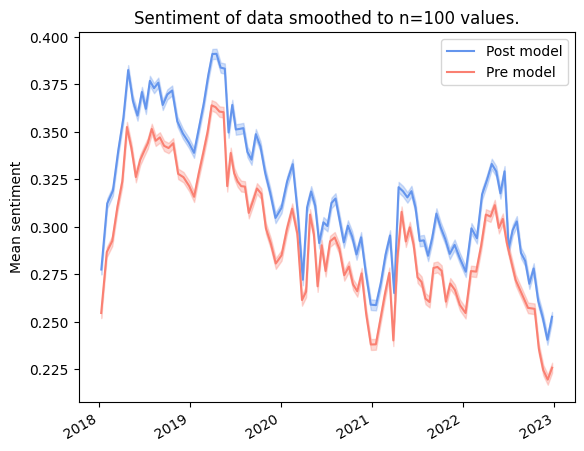

In [79]:
alpha = .3

plt.plot(smooth_post['date'], smooth_post['sentiment'], label='Post model', color='CornflowerBlue')
plt.fill_between(smooth_post['date'], (smooth_post['sentiment']-smooth_post['ci']), (smooth_post['sentiment']+smooth_post['ci']), color='CornflowerBlue', alpha=alpha)

plt.plot(smooth_pre['date'], smooth_pre['sentiment'], label="Pre model", color="salmon")
plt.fill_between(smooth_pre['date'], (smooth_pre['sentiment']-smooth_pre['ci']), (smooth_pre['sentiment']+smooth_pre['ci']), color='salmon', alpha=alpha)

plt.ylabel("Mean sentiment")
plt.xticks(rotation=30, ha='right')
plt.title(f"Sentiment of data smoothed to n={smoothness} values.")
plt.legend()
plt.show()

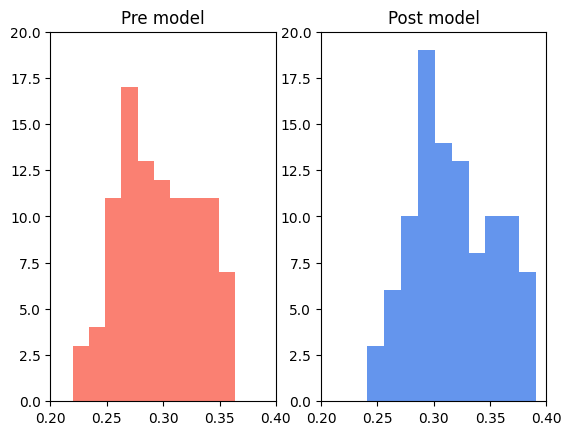

In [88]:
fig, axs = plt.subplots(1,2)

axs[0].hist(smooth_pre['sentiment'], color="salmon")
axs[0].set_title("Pre model")
axs[0].set_xlim(0.2, 0.4)
axs[0].set_ylim(0, 20)

axs[1].hist(smooth_post['sentiment'], color='CornflowerBlue')
axs[1].set_title("Post model")
axs[1].set_xlim(0.2, 0.4)
axs[1].set_ylim(0, 20)

plt.show()

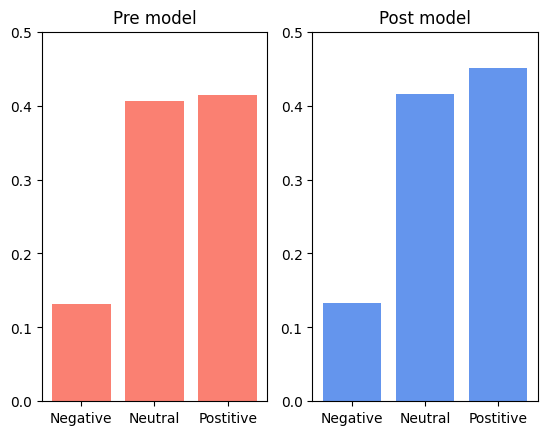

In [10]:
val_counts_post = post_data['sentiment'].value_counts()
val_counts_pre = pre_data['sentiment'].value_counts()
lbls = list(val_counts_post.keys())

fig, axs = plt.subplots(1,2)
axs[0].bar(lbls, val_counts_pre.values / len(post_data), color="red")
axs[0].set_title("Pre model")

axs[1].bar(lbls, val_counts_post.values / len(post_data), color='CornflowerBlue')
axs[1].set_title("Post model")

plt.setp(axs, xticks=[-1.0,0.0,1.0], xticklabels=['Negative', "Neutral", "Postitive"], yticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.show()

In [90]:
get_ci = lambda x, y: 1.96 * np.std(y)/np.sqrt(x)

def smooth_count(data, n=1000):
    smooth_data = list()
    step_size = int(len(data) / n)
    data.sort_values(by='date', inplace=True)
    for i in range(n):
        slice = data.iloc[i*step_size: (i+1)*step_size]
        val_count = slice['sentiment'].value_counts(normalize=True)
        smooth_data.append(
            {
                'date': slice['date'].mean(), 
                'negative': val_count.loc[-1],
                'neutral': val_count.loc[0], 
                'positive': val_count.loc[1],
                'ci_negative': get_ci(val_count.loc[-1] * len(slice['sentiment']), slice['sentiment']),
                'ci_neutral': get_ci(val_count.loc[0] * len(slice['sentiment']), slice['sentiment']),
                'ci_positive': get_ci(val_count.loc[1] * len(slice['sentiment']), slice['sentiment']),
            }
        )
    
    return smooth_data

smoothness = 100
smooth_count_post = pd.DataFrame(smooth_count(post_data, smoothness))
smooth_count_pre = pd.DataFrame(smooth_count(pre_data, smoothness))

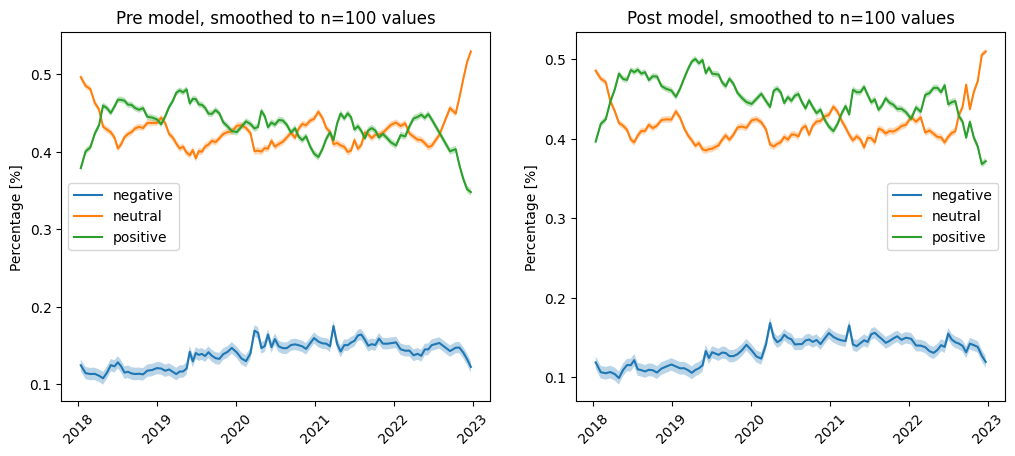

In [98]:
def create_mulitplot(data, model_labesl= ["Pre model", "Post model"], alpha=.3):
    fig, axs = plt.subplots(1,len(data))
    cats = ['negative', 'neutral', 'positive']
    
    for i, df in enumerate(data):
        for val in cats:
            ci = df[f"ci_{val}"]
            axs[i].plot(df['date'], df[val], label = val)
            axs[i].fill_between(df['date'], (df[val]-ci), (df[val]+ci), alpha=alpha)
            
        axs[i].set_title(f"{model_labesl[i]}, smoothed to n={smoothness} values")
        axs[i].set_ylabel("Percentage [%]")
        axs[i].legend()   
        
    plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45)
    plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)
    plt.subplots_adjust(right=1.6)
    plt.show() 
        
create_mulitplot([smooth_count_pre, smooth_count_post])

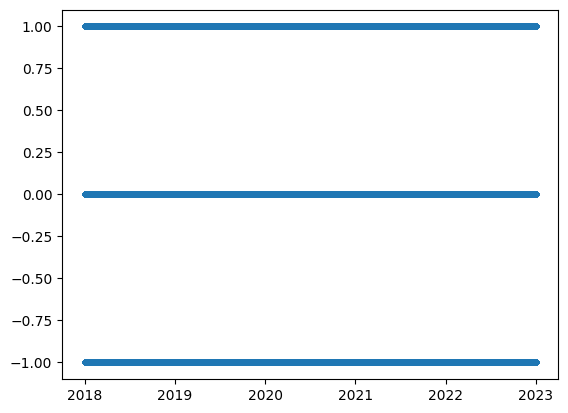

In [ ]:
plt.plot(post_data['date'], post_data['sentiment'], '.')

In [23]:
files = glob("../time_lm_data/*.csv")

dates = {
    '../time_lm_data\\sentiment_subsample_base_model_10_quarterly_data_2022_Q3.csv': pd.to_datetime("2022-06-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_1_quarterly_data_2020_Q2.csv': pd.to_datetime("2020-03-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_2_quarterly_data_2020_Q3.csv': pd.to_datetime("2020-06-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_3_quarterly_data_2020_Q4.csv': pd.to_datetime("2020-09-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_4_quarterly_data_2021_Q1.csv': pd.to_datetime("2021-01-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_5_quarterly_data_2021_Q2.csv': pd.to_datetime("2021-03-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_6_quarterly_data_2021_Q3.csv': pd.to_datetime("2021-03-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_7_quarterly_data_2021_Q4.csv': pd.to_datetime("2021-09-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_8_quarterly_data_2022_Q1.csv': pd.to_datetime("2022-01-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_9_quarterly_data_2022_Q2.csv': pd.to_datetime("2022-03-01", format="%Y-%m-%d"),
}


prosessed_data = list()
for file in files:
    f_data = pd.read_csv(file)
    f_data['sentiment'] = f_data['sentiment'].map({"{'label': 'positive'}": 1, "{'label': 'neutral'}": 0, "{'label': 'negative'}": -1})
    ci = 1.96 * np.std(f_data['sentiment']) / np.sqrt(len(f_data['sentiment']))
    prosessed_data.append({'date': dates[file], 'sentiment': f_data['sentiment'].mean(), 'ci': ci})

prosessed_data = pd.DataFrame(prosessed_data)

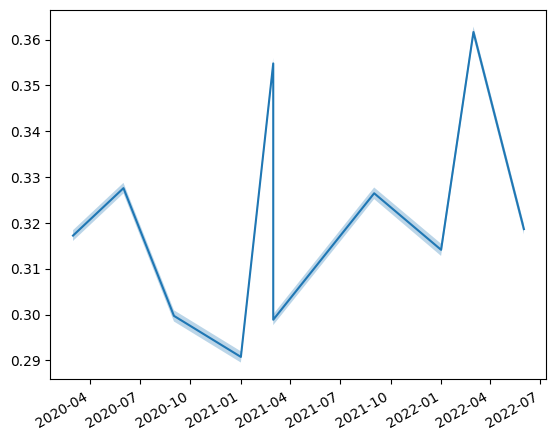

In [25]:
prosessed_data.sort_values(by="date", inplace=True)
senti = prosessed_data['sentiment']
ci = prosessed_data['ci']

plt.plot(prosessed_data['date'], prosessed_data['sentiment'])
plt.fill_between(prosessed_data['date'], (senti-ci), (senti+ci), alpha=.3)
plt.xticks(rotation=30, ha='right')
plt.show()

In [55]:
files = glob("../time_lm_data/*.csv")

dates = {
    '../time_lm_data\\sentiment_subsample_base_model_10_quarterly_data_2022_Q3.csv': pd.to_datetime("2022-06-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_1_quarterly_data_2020_Q2.csv': pd.to_datetime("2020-03-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_2_quarterly_data_2020_Q3.csv': pd.to_datetime("2020-06-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_3_quarterly_data_2020_Q4.csv': pd.to_datetime("2020-09-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_4_quarterly_data_2021_Q1.csv': pd.to_datetime("2021-01-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_5_quarterly_data_2021_Q2.csv': pd.to_datetime("2021-03-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_6_quarterly_data_2021_Q3.csv': pd.to_datetime("2021-03-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_7_quarterly_data_2021_Q4.csv': pd.to_datetime("2021-09-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_8_quarterly_data_2022_Q1.csv': pd.to_datetime("2022-01-01", format="%Y-%m-%d"),
    '../time_lm_data\\sentiment_subsample_base_model_9_quarterly_data_2022_Q2.csv': pd.to_datetime("2022-03-01", format="%Y-%m-%d"),
}

get_ci = lambda x, y: 1.96 * np.std(y)/np.sqrt(x)

prosessed_data = list()
for file in files:
    f_data = pd.read_csv(file)
    cts = f_data['sentiment'].value_counts(normalize=True)
    sent_vals = f_data['sentiment'].map({"{'label': 'positive'}": 1, "{'label': 'neutral'}": 0, "{'label': 'negative'}": -1})
    data_count = {
        'stamp': "_".join(file.split("_")[-2:])[:-4], 
        'date': dates[file], 
        'positive': cts["{'label': 'positive'}"], 
        'neutral': cts["{'label': 'neutral'}"], 
        'negative': cts["{'label': 'negative'}"],
        'ci_positive': get_ci(cts["{'label': 'positive'}"] * len(sent_vals), sent_vals),
        'ci_neutral': get_ci(cts["{'label': 'neutral'}"] * len(sent_vals), sent_vals), 
        'ci_negative': get_ci(cts["{'label': 'negative'}"] * len(sent_vals), sent_vals),
    }
    prosessed_data.append(data_count)

prosessed_data = pd.DataFrame(prosessed_data)

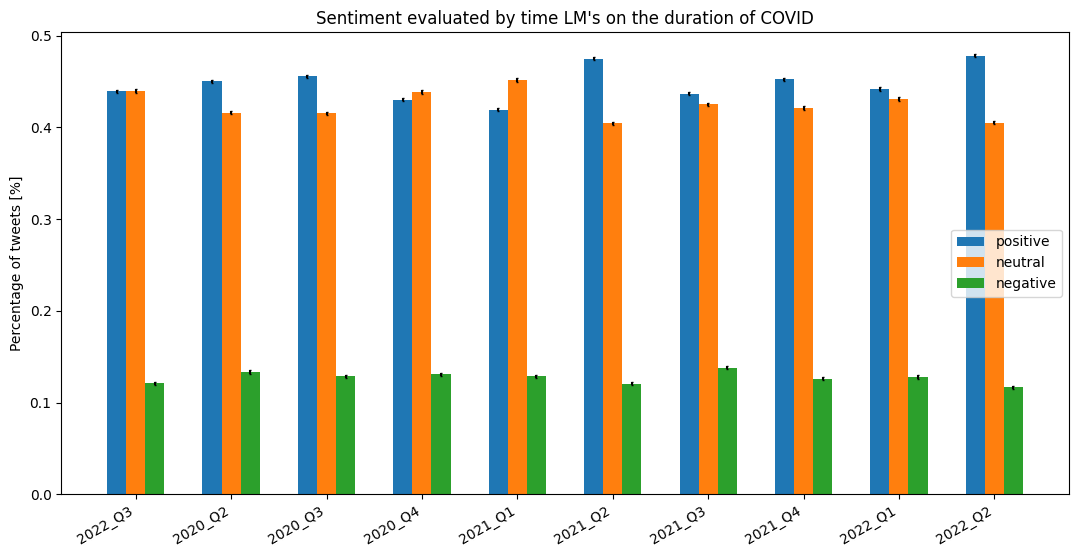

In [69]:
bar_width = .2
x_axis = np.arange(len(prosessed_data))

plt.figure(figsize=(13,6))

plt.bar(x_axis - bar_width, prosessed_data['positive'], width=bar_width, label="positive", yerr = prosessed_data["ci_positive"], capsize=1)
plt.bar(x_axis, prosessed_data['neutral'] , width=bar_width, label="neutral", yerr = prosessed_data["ci_positive"], capsize=1)
plt.bar(x_axis + bar_width, prosessed_data['negative'], width=bar_width, label="negative", yerr = prosessed_data["ci_positive"], capsize=1)

plt.legend()
plt.xticks(x_axis, prosessed_data['stamp'], rotation=30, ha='right')
plt.title("Sentiment evaluated by time LM's on the duration of COVID")
plt.ylabel("Percentage of tweets [%]")

plt.show()